# No-Transaction Band Network

In [1]:
!curl --silent https://raw.githubusercontent.com/pfnet-research/NoTransactionBandNetwork/main/utils.py > utils.py

In [2]:
import typing

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn
import torch
import torch.nn.functional as fn
from torch.optim import Adam
from tqdm import tqdm

from utils import MultiLayerPerceptron
from utils import clamp
from utils import entropic_loss
from utils import european_option_delta
from utils import generate_geometric_brownian_motion
from utils import to_premium

In [3]:
seaborn.set_style("whitegrid")

FONTSIZE = 18
matplotlib.rcParams["figure.figsize"] = (10, 5)
matplotlib.rcParams["figure.dpi"] = 300
matplotlib.rcParams["figure.titlesize"] = FONTSIZE
matplotlib.rcParams["font.family"] = "sans-serif"
matplotlib.rcParams["legend.fontsize"] = FONTSIZE
matplotlib.rcParams["xtick.labelsize"] = FONTSIZE
matplotlib.rcParams["ytick.labelsize"] = FONTSIZE
matplotlib.rcParams["axes.labelsize"] = FONTSIZE
matplotlib.rcParams["axes.titlesize"] = FONTSIZE
matplotlib.rcParams["savefig.bbox"] = "tight"
matplotlib.rcParams["savefig.pad_inches"] = 0.1
matplotlib.rcParams["lines.linewidth"] = 2
matplotlib.rcParams["axes.linewidth"] = 1.6

In [4]:
if not torch.cuda.is_available():
    raise RuntimeWarning(
        "CUDA is not available. "
        "If you're using Google Colab, you can enable GPUs as: "
        "https://colab.research.google.com/notebooks/gpu.ipynb"
    )

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Default device:", DEVICE)

Default device: cuda:0


In [5]:
# In each epoch, N_PATHS brownian motion time-series are generated.
N_PATHS = 10000
# How many times a model is updated in the experiment.
N_EPOCHS = 50

In [6]:
def to_numpy(tensor: torch.Tensor) -> np.array:
    return tensor.cpu().detach().numpy()

## Define derivatives

We prepare a European option and a lookback option.

European option is the most popular option.

Lookback option is an exotic option whose payoff depends on the price history.

In [7]:
def european_option_payoff(prices: torch.Tensor, strike=1.0) -> torch.Tensor:
    """
    Return the payoff of a European option.

    Parameters
    ----------
    prices : torch.Tensor, shape (n_steps, n_paths)
        Prices of the underlying asset.

    Returns
    -------
    payoff : torch.Tensor, shape (n_paths, )
    """
    return fn.relu(prices[-1, :] - strike)

In [8]:
def lookback_option_payoff(prices: torch.Tensor, strike=1.03) -> torch.Tensor:
    """
    Return the payoff of a lookback option.

    Parameters
    ----------
    prices : torch.Tensor, shape (n_steps, n_paths)
        Prices of the underlying asset.

    Returns
    -------
    payoff : torch.Tensor, shape (n_paths, )
    """
    return fn.relu(torch.max(prices, dim=0).values - strike)

## Experiment: European Option

### Compute profit and loss with hedging

A dealer sells a derivative to its customer and obliges a liability to settle the payoff at maturity.

The dealer may hedge the risk of this liability by trading an underlying asset of the derivative based on `hedging_model`.

The resulting profit and loss is obtained by adding up the payoff to the customer, capital gains from the underlying asset, and the transaction cost.

In [9]:
def compute_profit_and_loss(
    hedging_model: torch.nn.Module,
    payoff: typing.Callable[[torch.Tensor], torch.Tensor],
    cost: float,
    n_paths=N_PATHS,
    maturity=30 / 365,
    dt=1 / 365,
    volatility=0.2,
) -> torch.Tensor:
    """
    Return profit-loss distribution after hedging.

    Parameters
    ----------
    - hedging_model : torch.nn.Module
        Hedging model to fit.
    - payoff : callable[[torch.Tensor], torch.Tensor]
        Payoff function of the derivative to hedege.
    - cost : float
        Transaction cost of underlying asset.

    Returns
    -------
    profit_and_loss : torch.Tensor, shape (n_paths,)
    """
    # Prepare time-series of prices with shape (time, batch)
    prices = generate_geometric_brownian_motion(
        n_paths, maturity=maturity, dt=dt, volatility=volatility, device=DEVICE
    )

    hedge = torch.zeros_like(prices[:1]).reshape(-1)
    pnl = 0
    # Simulate hedging over time.
    for n in range(prices.shape[0] - 1):
        # Prepare a model input.
        x_log_moneyness = prices[n, :, None].log()
        x_time_expiry = torch.full_like(x_log_moneyness, maturity - n * dt)
        x_volatility = torch.full_like(x_log_moneyness, volatility)
        x = torch.cat([x_log_moneyness, x_time_expiry, x_volatility], 1)

        # Infer a preferable hedge ratio.
        prev_hedge = hedge
        hedge = hedging_model(x, prev_hedge)

        # Receive profit/loss from the original asset.
        pnl += hedge * (prices[n + 1] - prices[n])
        # Pay transaction cost.
        pnl -= cost * torch.abs(hedge - prev_hedge) * prices[n]

    # Pay the option's payoff to the customer.
    pnl -= payoff(prices)

    return pnl

### Create hedging models

Now let us create `hedging_model` as `torch.nn.Module`.

We employ two models here:
* **No-Transaction Band Network** (proposed architecture):
    - A multi-layer perceptron outputs a no-transaction band, and the next hedge ratio is obtained by clamping the current hedge ratio into this band.
    - Two outputs of the multi-layer perceptron are applied with [`LeakyReLU`](https://pytorch.org/docs/stable/generated/torch.nn.LeakyReLU.html#torch.nn.LeakyReLU), and then added/subtracted to the Black–Scholes’ delta to get the upper/lower-bound of the no-transaction band, respectively.
* **Feed-forward network** (baseline):
    - A multi-layer perception uses the current hedge ratio as an input to compute the next hedge ratio.
    - The output of a multi-layer perceptron is applied with [`tanh`](https://pytorch.org/docs/stable/generated/torch.nn.Tanh.html#torch.nn.Tanh) function and then added to Black–Scholes’ delta to get the next hedge ratio.

In [10]:
class NoTransactionBandNet(torch.nn.Module):
    """
    No-transaction band network.

    Parameters
    ----------
    - in_features : int, default 3
        Number of input features.

    Examples
    --------
    >>> _ = torch.manual_seed(42)
    >>> m = NoTransactionBandNet()
    >>> x = torch.tensor([
    ...     [-0.01, 0.1, 0.2],
    ...     [ 0.00, 0.1, 0.2],
    ...     [ 0.01, 0.1, 0.2]])
    >>> prev = torch.full_like(x[:, 0], 0.5)
    >>> m(x, prev)
    tensor([..., ..., ...], grad_fn=<SWhereBackward>)
    """

    def __init__(self, in_features=3):
        super().__init__()

        # A four-layer MLP with 32 hidden neurons in each layer
        self.mlp = MultiLayerPerceptron(in_features, 2) # MultiLayerPerceptron(in_features (or n_units), out_features)
                                                        # out_features: for lower/upper band, respectively

    def forward(self, x, prev):
        # Black-Scholes' delta in the absence of transaction cost
        no_cost_delta = european_option_delta(x[:, 0], x[:, 1], x[:, 2]) # x: [log_m, TTM, vol]

        # Compute no-transaction band using the multi-layer perceptron
        band_width = self.mlp(x)
        lower = no_cost_delta - fn.leaky_relu(band_width[:, 0]) # negative_slope = 0.01
        upper = no_cost_delta + fn.leaky_relu(band_width[:, 1])

        # Hedge ratio at the next time step is obtained by clamping the previous one inside the band
        hedge = clamp(prev, lower, upper)

        return hedge

In [11]:
class FeedForwardNet(torch.nn.Module):
    """
    Feed-forward network with Black-Scholes delta.

    Parameters
    ----------
    - in_features : int, default 3
        Number of input features.

    Examples
    --------
    >>> _ = torch.manual_seed(42)
    >>> m = FeedForwardNet(3)
    >>> x = torch.tensor([
    ...     [-0.01, 0.1, 0.2],
    ...     [ 0.00, 0.1, 0.2],
    ...     [ 0.01, 0.1, 0.2]])
    >>> prev = torch.full_like(x[:, 0], 0.5)
    >>> m(x, prev)
    tensor([..., ..., ...], grad_fn=<AddBackward0>)
    """

    def __init__(self, in_features=3):
        super().__init__()

        # A four-layer MLP with 32 hidden neurons in each layer
        self.mlp = MultiLayerPerceptron(in_features + 1, 1) # MultiLayerPerceptron(in_features (or n_units), out_features)

    def forward(self, x, prev):
        # Black-Scholes' delta in the absence of transaction cost
        no_cost_delta = european_option_delta(x[:, 0], x[:, 1], x[:, 2]) # x: [log_m, TTM, vol]

        # Multi-layer perceptron directly computes the hedge ratio at the next time step - w/o clamp
        x = torch.cat((x, prev.reshape(-1, 1)), 1)
        x = self.mlp(x).reshape(-1)
        x = torch.tanh(x)
        hedge = no_cost_delta + x

        return hedge

In [12]:
torch.manual_seed(42)
model_ntb = NoTransactionBandNet().to(DEVICE)
torch.manual_seed(42)
model_ffn = FeedForwardNet().to(DEVICE)

### Compute profit and loss before training

In [13]:
torch.manual_seed(42)
pnl_ntb = compute_profit_and_loss(model_ntb, european_option_payoff, cost=1e-3)
torch.manual_seed(42)
pnl_ffn = compute_profit_and_loss(model_ffn, european_option_payoff, cost=1e-3)

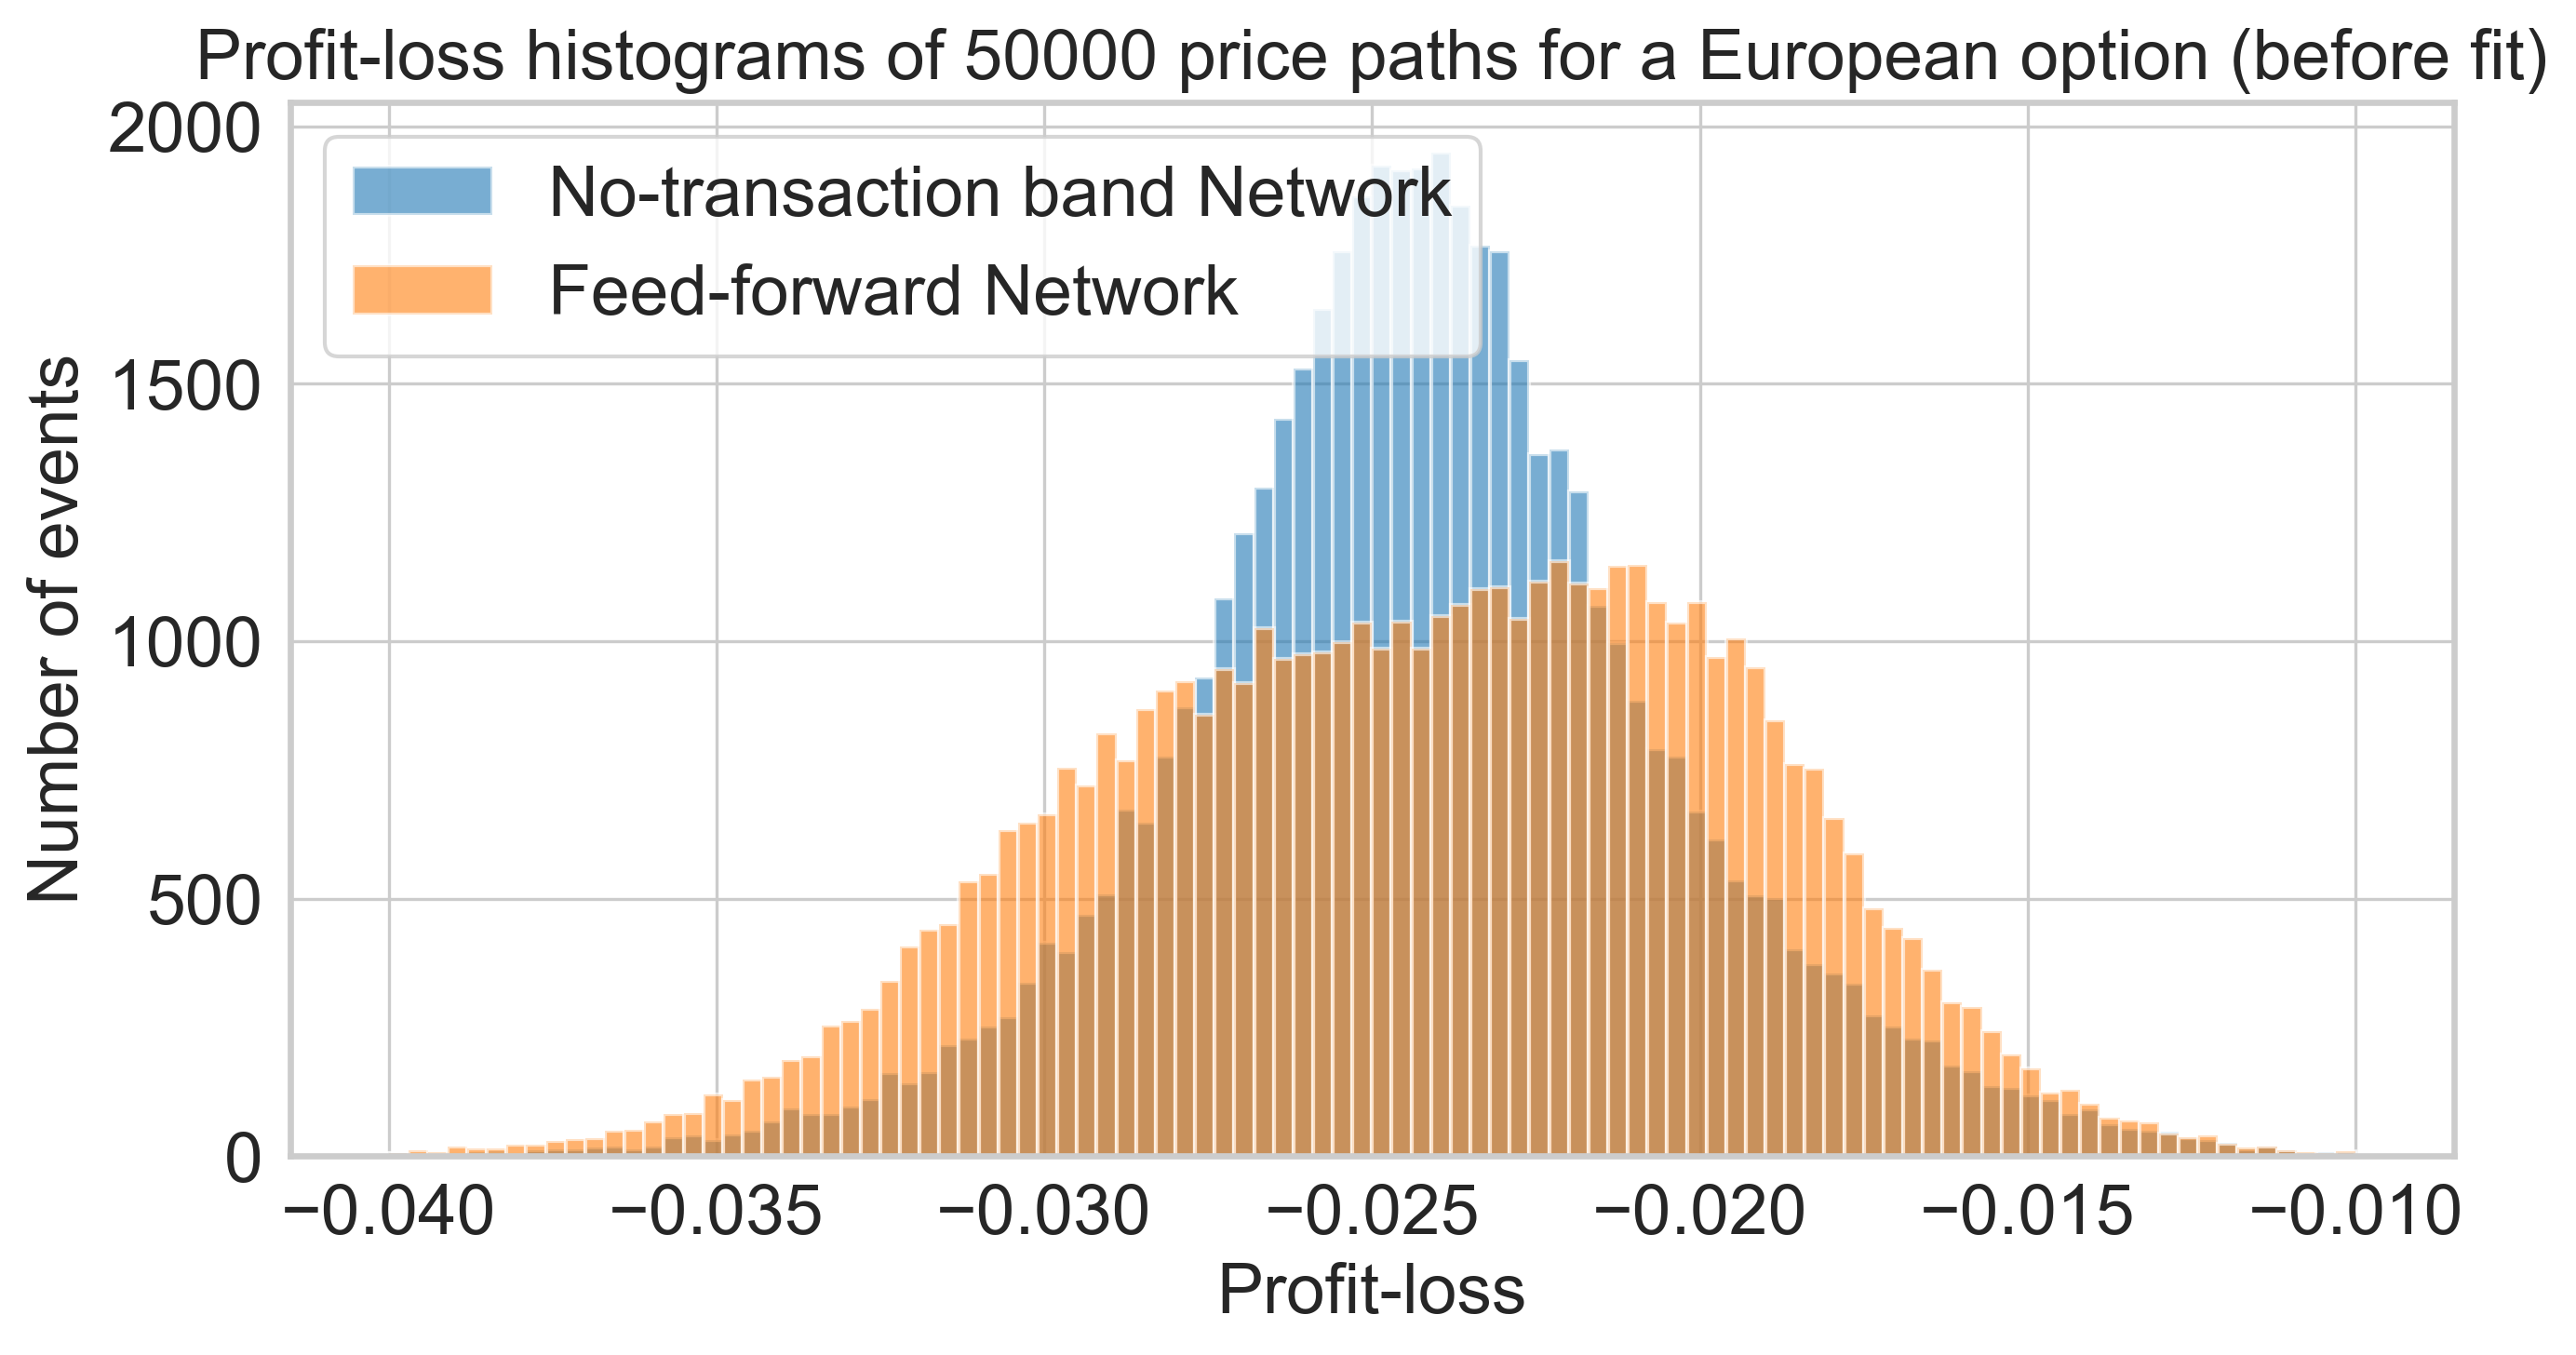

In [14]:
plt.figure()
plt.hist(
    to_numpy(pnl_ntb),
    bins=100,
    range=(-0.04, -0.01),
    alpha=0.6,
    label="No-transaction band Network",
)
plt.hist(
    to_numpy(pnl_ffn),
    bins=100,
    range=(-0.04, -0.01),
    alpha=0.6,
    label="Feed-forward Network",
)
plt.title(
    "Profit-loss histograms of 50000 price paths for a European option (before fit)"
)
plt.xlabel("Profit-loss")
plt.ylabel("Number of events")
plt.legend()
plt.show()

The profit and loss distributions with hedging are shown in the histograms above.

These distributions are not optimal since `hedging_model`s are not yet trained.

- ??? Hedging model이 학습 안됐는데 어떻게 PnL을 찍어?
- 찍을 수 있다고 해도, 그게 무슨 의미가 있는데?
    - randomly initialized로 찍은건가? --> again, 무슨 의미가 있는데?

In [15]:
print(model_ffn.parameters)
print(list(model_ffn.parameters()))

<bound method Module.parameters of FeedForwardNet(
  (mlp): MultiLayerPerceptron(
    (0): Linear(in_features=4, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=32, bias=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=32, bias=True)
    (7): ReLU()
    (8): Linear(in_features=32, out_features=1, bias=True)
  )
)>
[Parameter containing:
tensor([[ 0.3823,  0.4150, -0.1171,  0.4593],
        [-0.1096,  0.1009, -0.2434,  0.2936],
        [ 0.4408, -0.3668,  0.4346,  0.0936],
        [ 0.3694,  0.0677,  0.2411, -0.0706],
        [ 0.3854,  0.0739, -0.2334,  0.1274],
        [-0.2304, -0.0586, -0.2031,  0.3317],
        [-0.3947, -0.2305, -0.1412, -0.3006],
        [ 0.0472, -0.4938,  0.4516, -0.4247],
        [ 0.3860,  0.0832, -0.1624,  0.3090],
        [ 0.0779,  0.4040,  0.0547, -0.1577],
        [ 0.1343, -0.1356,  0.2104,  0.4464],
        [ 0.2890, -0

### Fit hedging models

We train hedging models so that they minimize the `entropic_loss`, or equivalently, maximize the expected utility.

In [16]:
def fit(
    hedging_model: torch.nn.Module,
    payoff: typing.Callable[[torch.Tensor], torch.Tensor],
    cost: float,
    n_epochs=N_EPOCHS,
) -> list:
    """
    Fit a hedging model to hedge the given derivative.

    Parameters
    ----------
    - hedging_model : torch.nn.Module
        Hedging model to fit.
    - payoff : callable[[torch.Tensor], torch.Tensor]
        Payoff function of the derivative to hedege.
    - cost : float, default 0.0
        Transaction cost of the underlying asset.
    - n_epochs : int, default N_EPOCHS
        How many times a hedging model is updated in the experiment.

    Returns
    -------
    loss_history : list[float]
        History of training loss.
    """
    optim = Adam(hedging_model.parameters())

    loss_history = []
    progress = tqdm(range(n_epochs))

    for _ in progress:
        optim.zero_grad()
        pnl = compute_profit_and_loss(hedging_model, payoff, cost=cost)
        loss = entropic_loss(pnl)
        loss.backward()
        optim.step()

        progress.desc = f"Loss={loss:.5f}"
        loss_history.append(loss.item())

    return loss_history

In [17]:
torch.manual_seed(42)
history_ntb = fit(model_ntb, european_option_payoff, cost=1e-3)
torch.manual_seed(42)
history_ffn = fit(model_ffn, european_option_payoff, cost=1e-3)

Loss=1.02312: 100%|██████████████████████████| 200/200 [00:09<00:00, 20.14it/s]


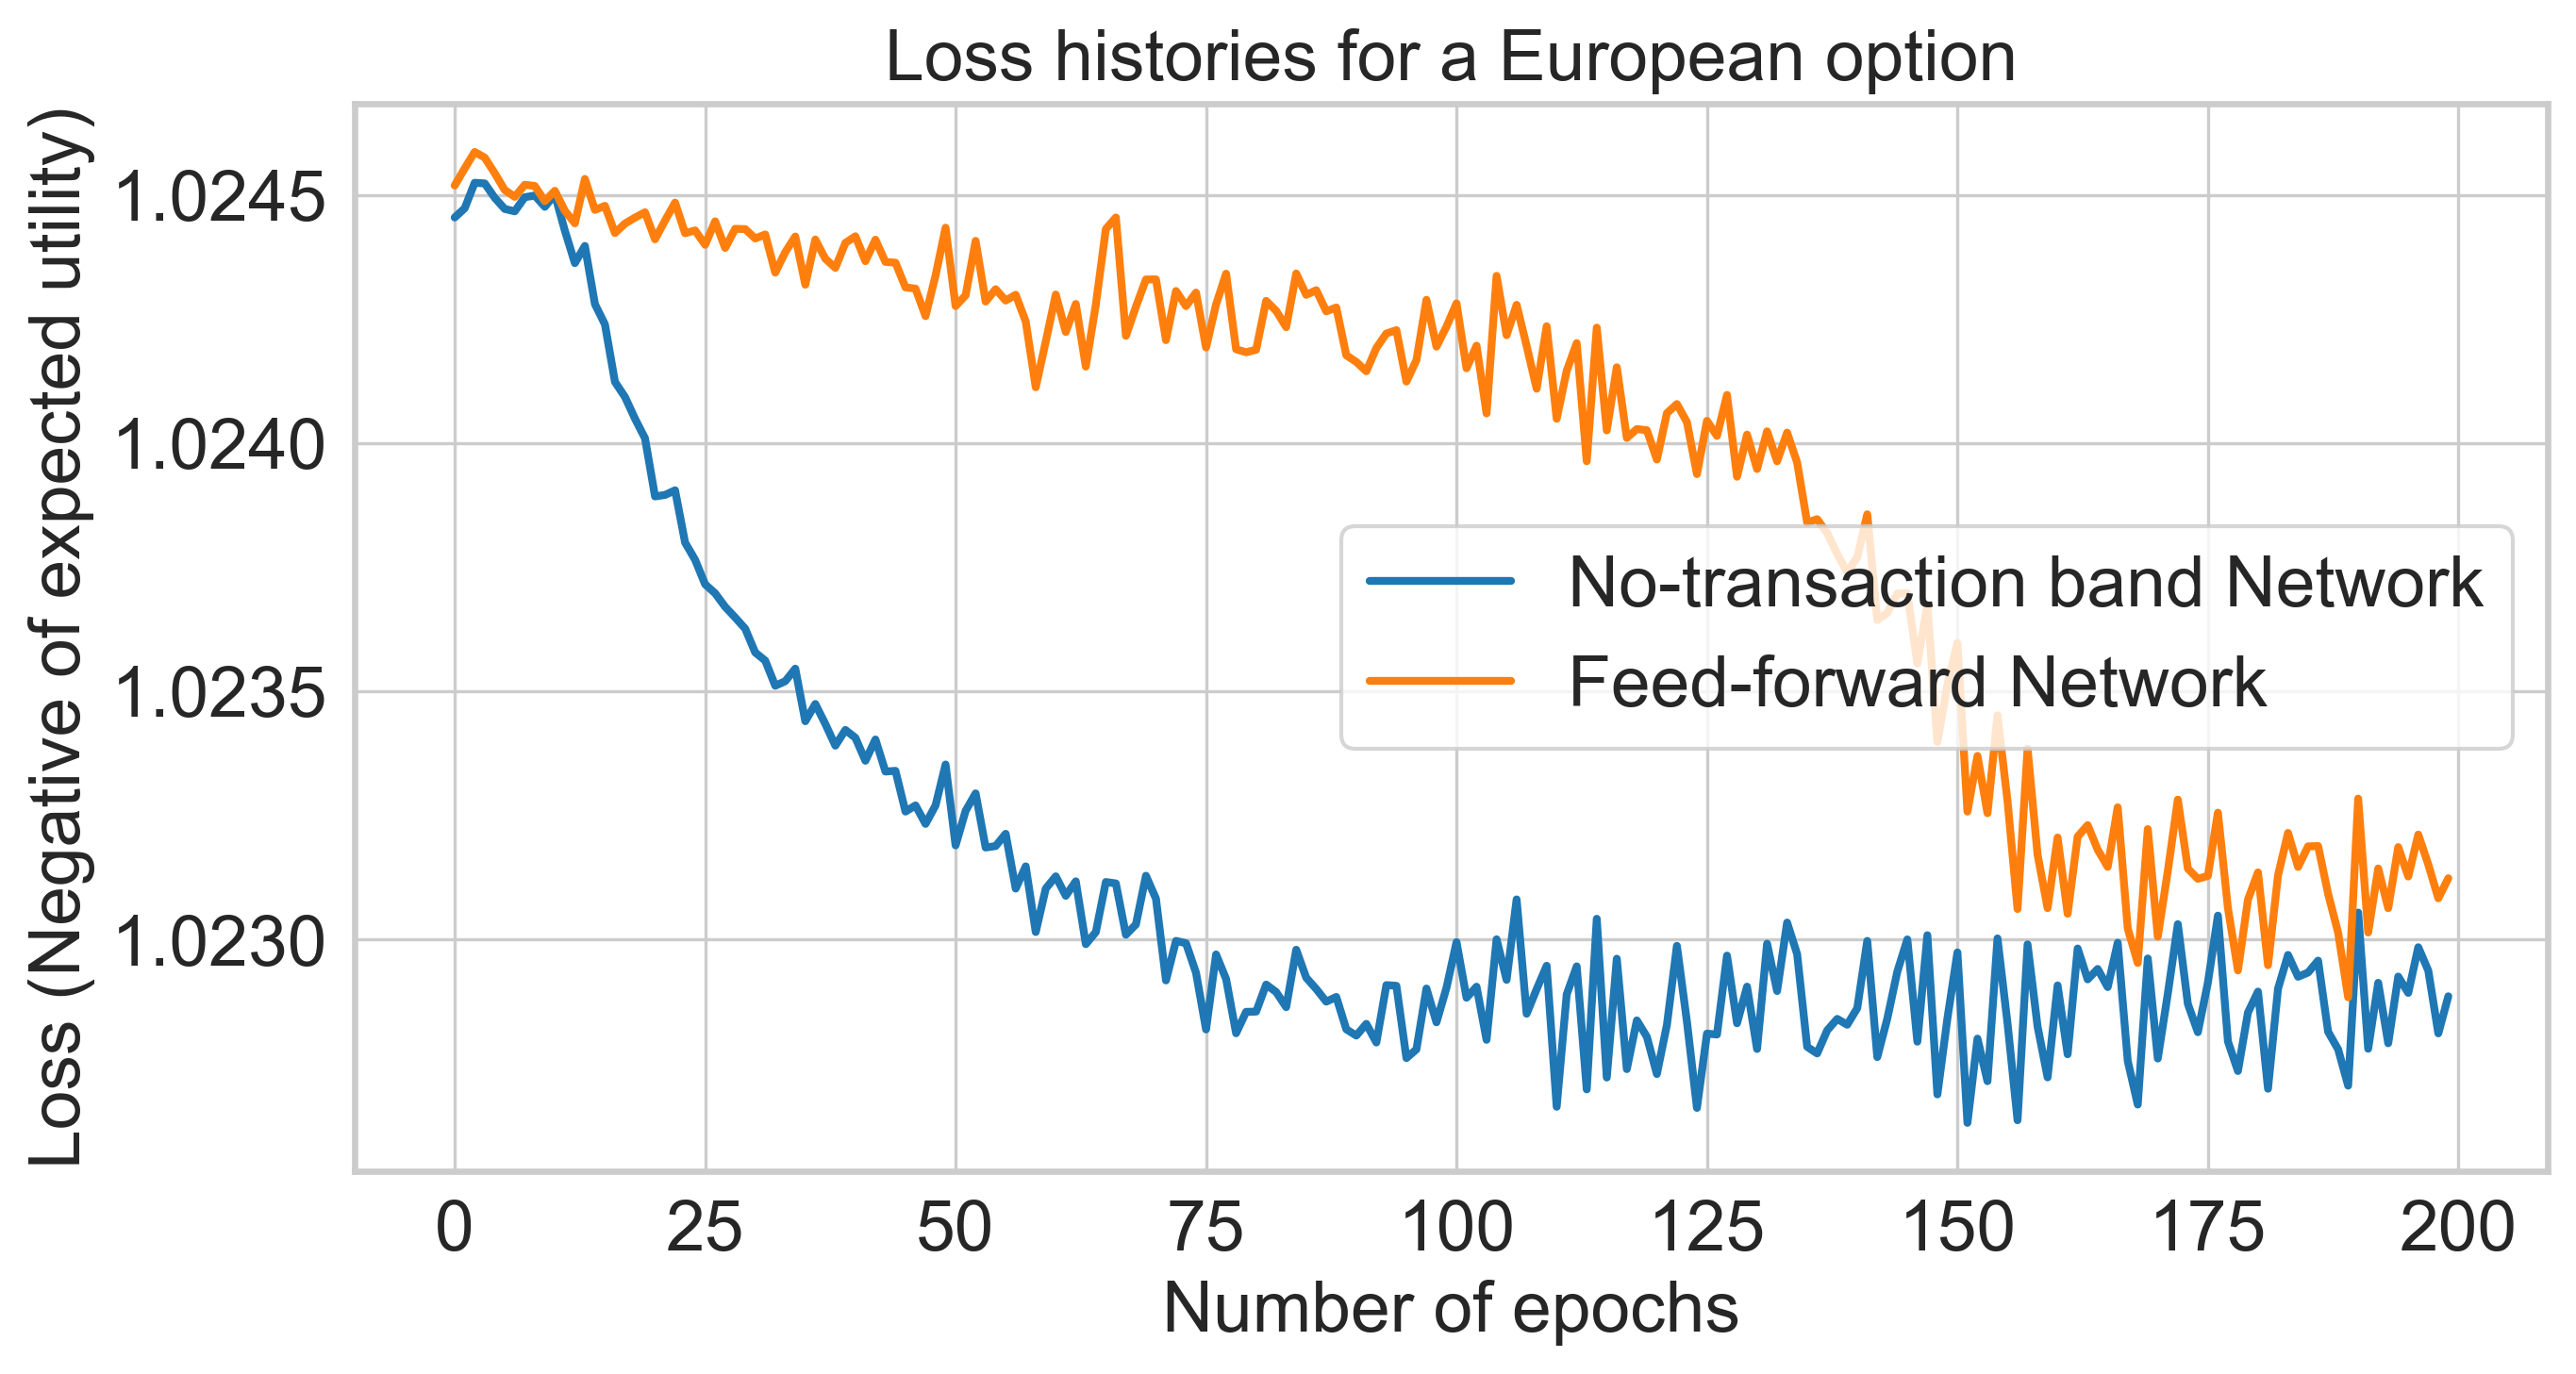

In [18]:
plt.figure()
plt.plot(history_ntb, label="No-transaction band Network")
plt.plot(history_ffn, label="Feed-forward Network")
plt.xlabel("Number of epochs")
plt.ylabel("Loss (Negative of expected utility)")
plt.title("Loss histories for a European option")
plt.legend()
plt.show()

The learning histories above demonstrate that the no-transaction band network can be trained much quicker than the ordinary feed-forward network.

The fluctuations observed after around 100th epoch are mostly due to variances of Monte Carlo paths of the asset prices.

### Compute the profit-loss distributions with hedging

In [19]:
torch.manual_seed(42)
pnl_ntb = compute_profit_and_loss(model_ntb, european_option_payoff, cost=1e-3)
torch.manual_seed(42)
pnl_ffn = compute_profit_and_loss(model_ffn, european_option_payoff, cost=1e-3)

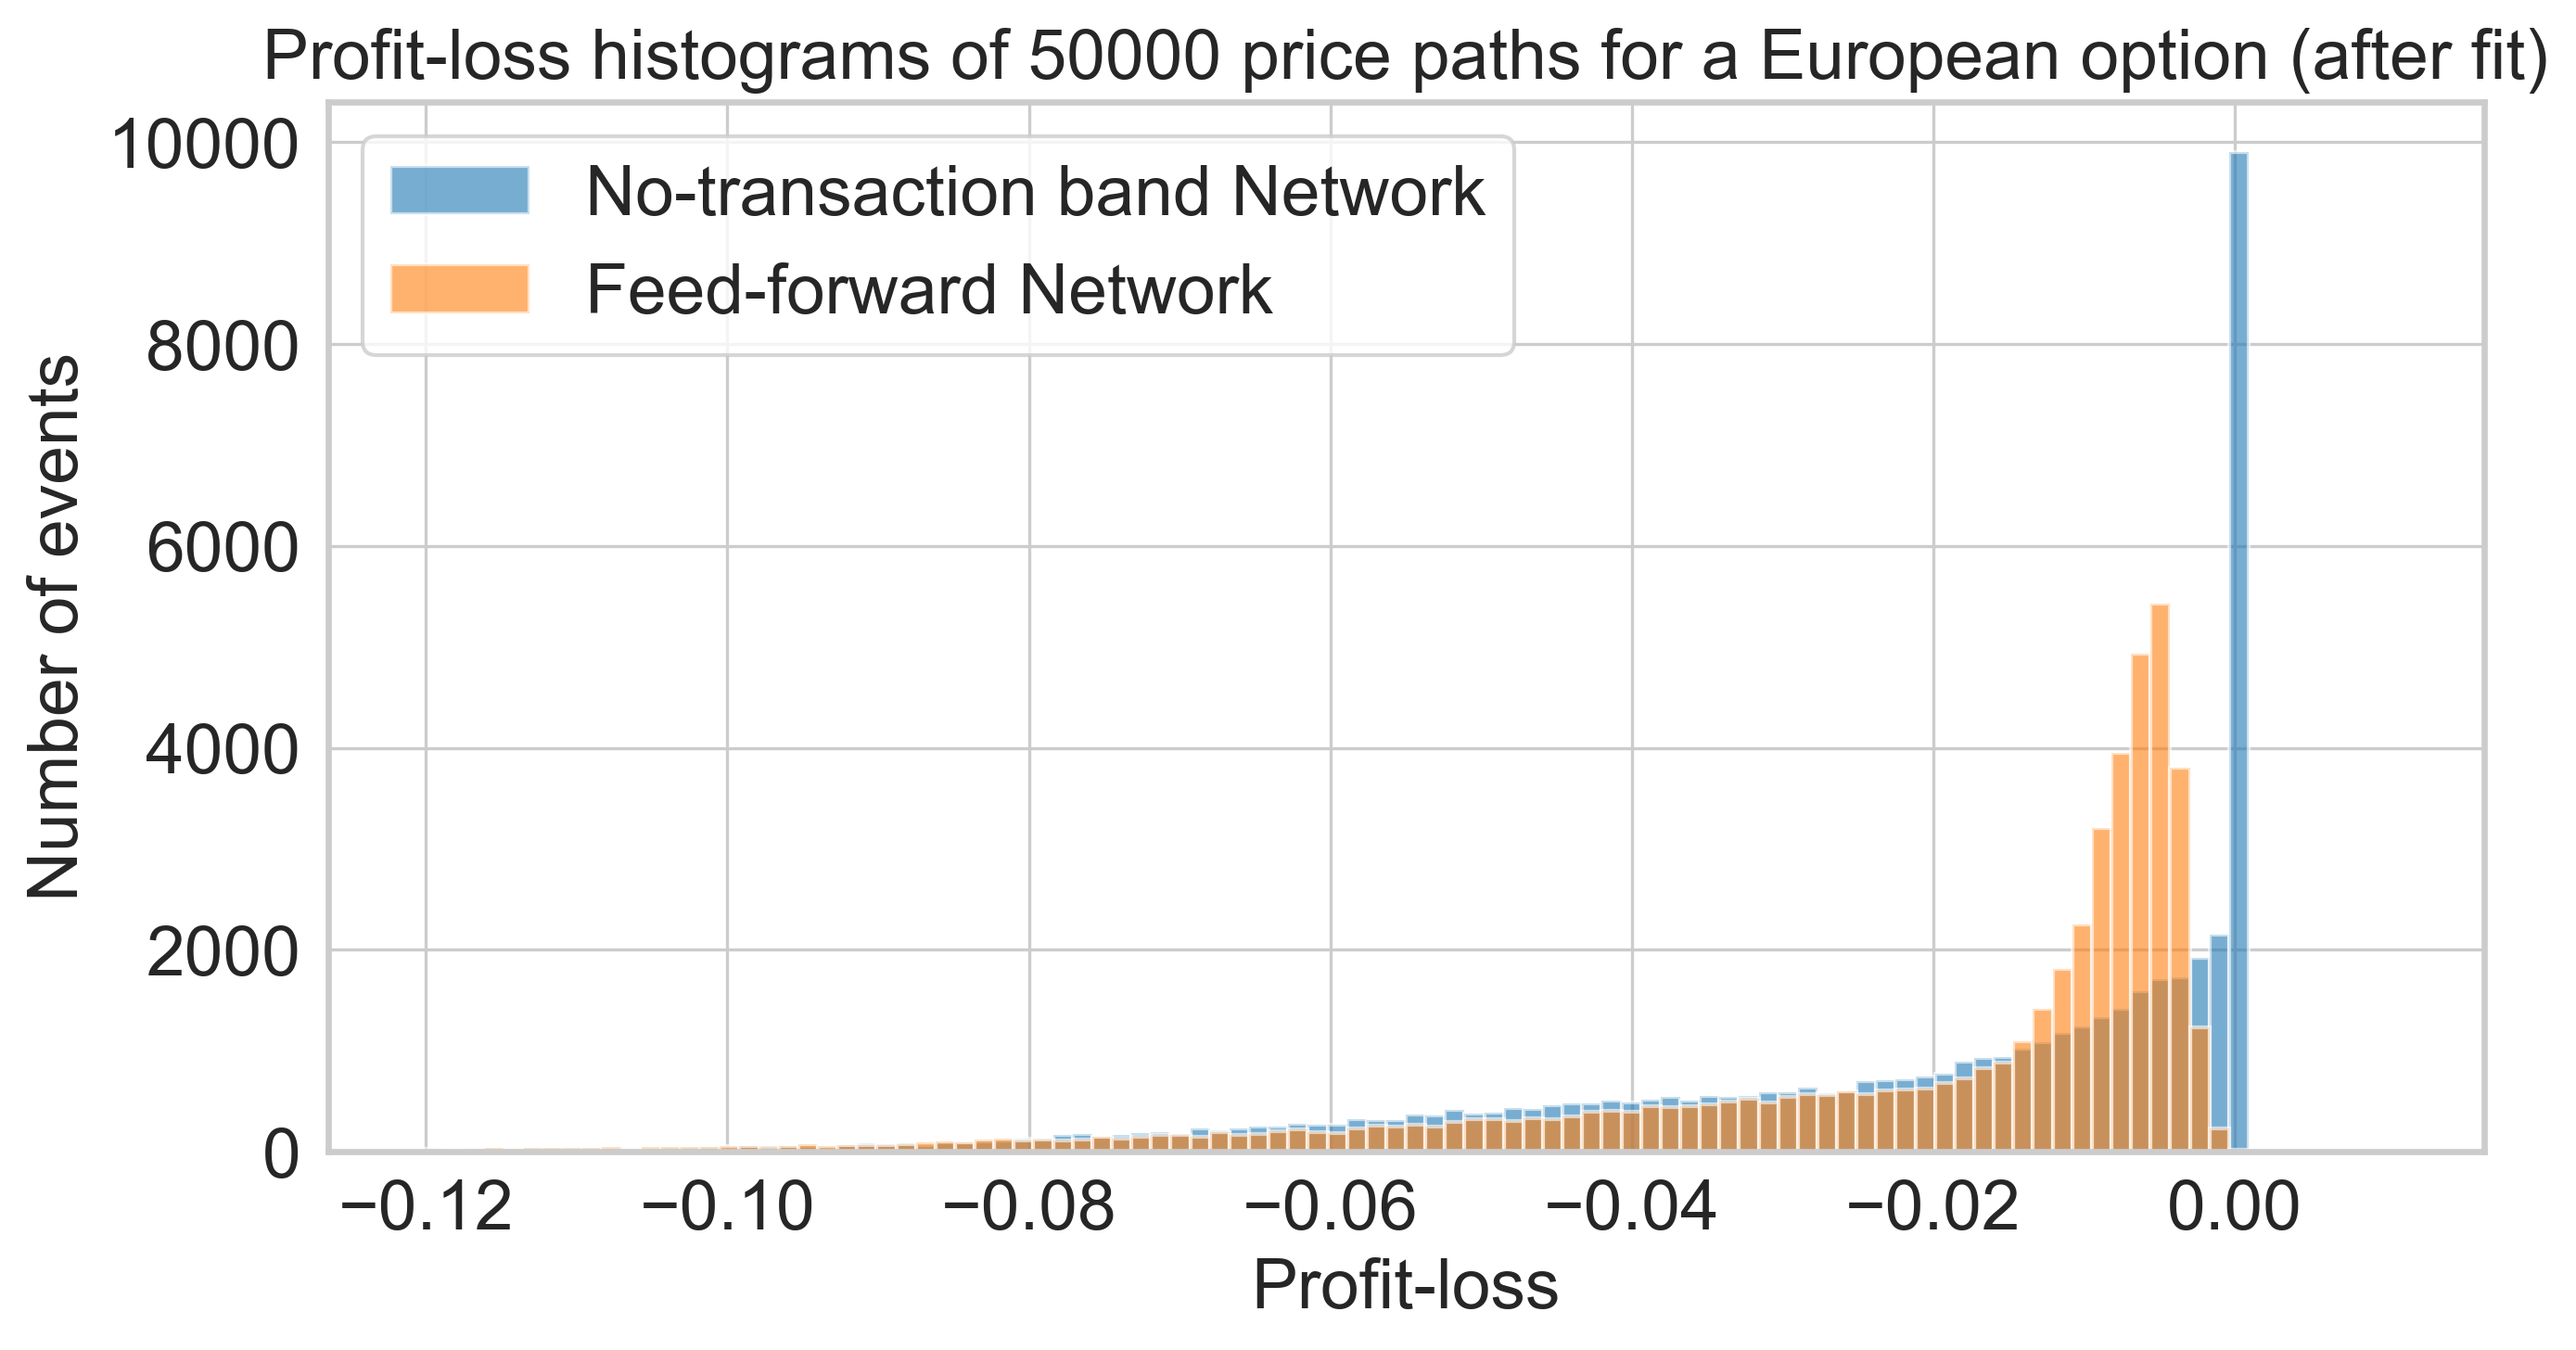

In [20]:
plt.figure()
plt.hist(
    to_numpy(pnl_ntb),
    bins=100,
    range=(-0.12, 0.01),
    alpha=0.6,
    label="No-transaction band Network",
)
plt.hist(
    to_numpy(pnl_ffn),
    bins=100,
    range=(-0.12, 0.01),
    alpha=0.6,
    label="Feed-forward Network",
)
plt.title(
    "Profit-loss histograms of 50000 price paths for a European option (after fit)"
)
plt.xlabel("Profit-loss")
plt.ylabel("Number of events")
plt.legend()
plt.show()

The histograms of the profit and loss after hedging look like above.

The no-transaction band network saves on transaction cost while avoiding great losses.

### Evaluate the best premium of the derivative

Now, we are ready to define the premium of the derivative.

Premium of a derivative is defined as the guaranteed amount of cash which is as preferable as the profit-loss after hedging in terms of the exponential utility.

In [21]:
def evaluate_premium(
    hedging_model: torch.nn.Module,
    payoff: typing.Callable[[torch.Tensor], torch.Tensor],
    cost: float,
    n_times=20,
) -> float:
    """
    Evaluate the premium of the given derivative.

    Parameters
    ----------
    - hedging_model : torch.nn.Module
        Hedging model to fit.
    - payoff : callable[[torch.Tensor], torch.Tensor]
        Payoff function of the derivative to hedege.
    - cost : float, default 0.0
        Transaction cost of underlying asset.
    - n_times : int, default 20
        If `n_times > 1`, return ensemble mean of the results
        from multiple simulations.

    Returns
    -------
    premium : float
    """
    with torch.no_grad():
        p = lambda: -to_premium(
            compute_profit_and_loss(hedging_model, payoff, cost=cost)
        ).item()
        return float(np.mean([p() for _ in range(n_times)]))

In [22]:
torch.manual_seed(42)
premium_ntb = evaluate_premium(model_ntb, european_option_payoff, cost=1e-3)
torch.manual_seed(42)
premium_ffn = evaluate_premium(model_ffn, european_option_payoff, cost=1e-3)

The no-transaction band network allows for a cheaper price.

In [23]:
print("Premium of a European option evaluated by the no-transaction band network :\t", premium_ntb)
print("Premium of a European option evaluated by the feed-forward band network   :\t", premium_ffn)

Premium of a European option evaluated by the no-transaction band network :	 0.022546883579343556
Premium of a European option evaluated by the feed-forward band network   :	 0.02277194829657674


In [31]:
model_ntb

NoTransactionBandNet(
  (mlp): MultiLayerPerceptron(
    (0): Linear(in_features=3, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=32, bias=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=32, bias=True)
    (7): ReLU()
    (8): Linear(in_features=32, out_features=2, bias=True)
  )
)

In [24]:
premium_reduced = (premium_ffn - premium_ntb) / premium_ffn * 100
print("Reduced premium of a European option :\t", f"{premium_reduced:.4f} %")

Reduced premium of a European option :	 0.9883 %


## Experiment: Lookback Option

Let us carry out the same experiment for a lookback option.

Although we omit the cumulative maximum of the asset price, which is an important feature for a lookback option, for simlicity, the no-transaction band network attains a fairly good hedging strategy.

### Create hedging models

In [25]:
torch.manual_seed(42)
model_ntb = NoTransactionBandNet().to(DEVICE)
torch.manual_seed(42)
model_ffn = FeedForwardNet().to(DEVICE)

### Fit hedging models

In [26]:
torch.manual_seed(42)
history_ntb = fit(model_ntb, lookback_option_payoff, cost=1e-3)
torch.manual_seed(42)
history_ffn = fit(model_ffn, lookback_option_payoff, cost=1e-3)

Loss=1.01896: 100%|██████████████████████████| 200/200 [00:14<00:00, 14.10it/s]


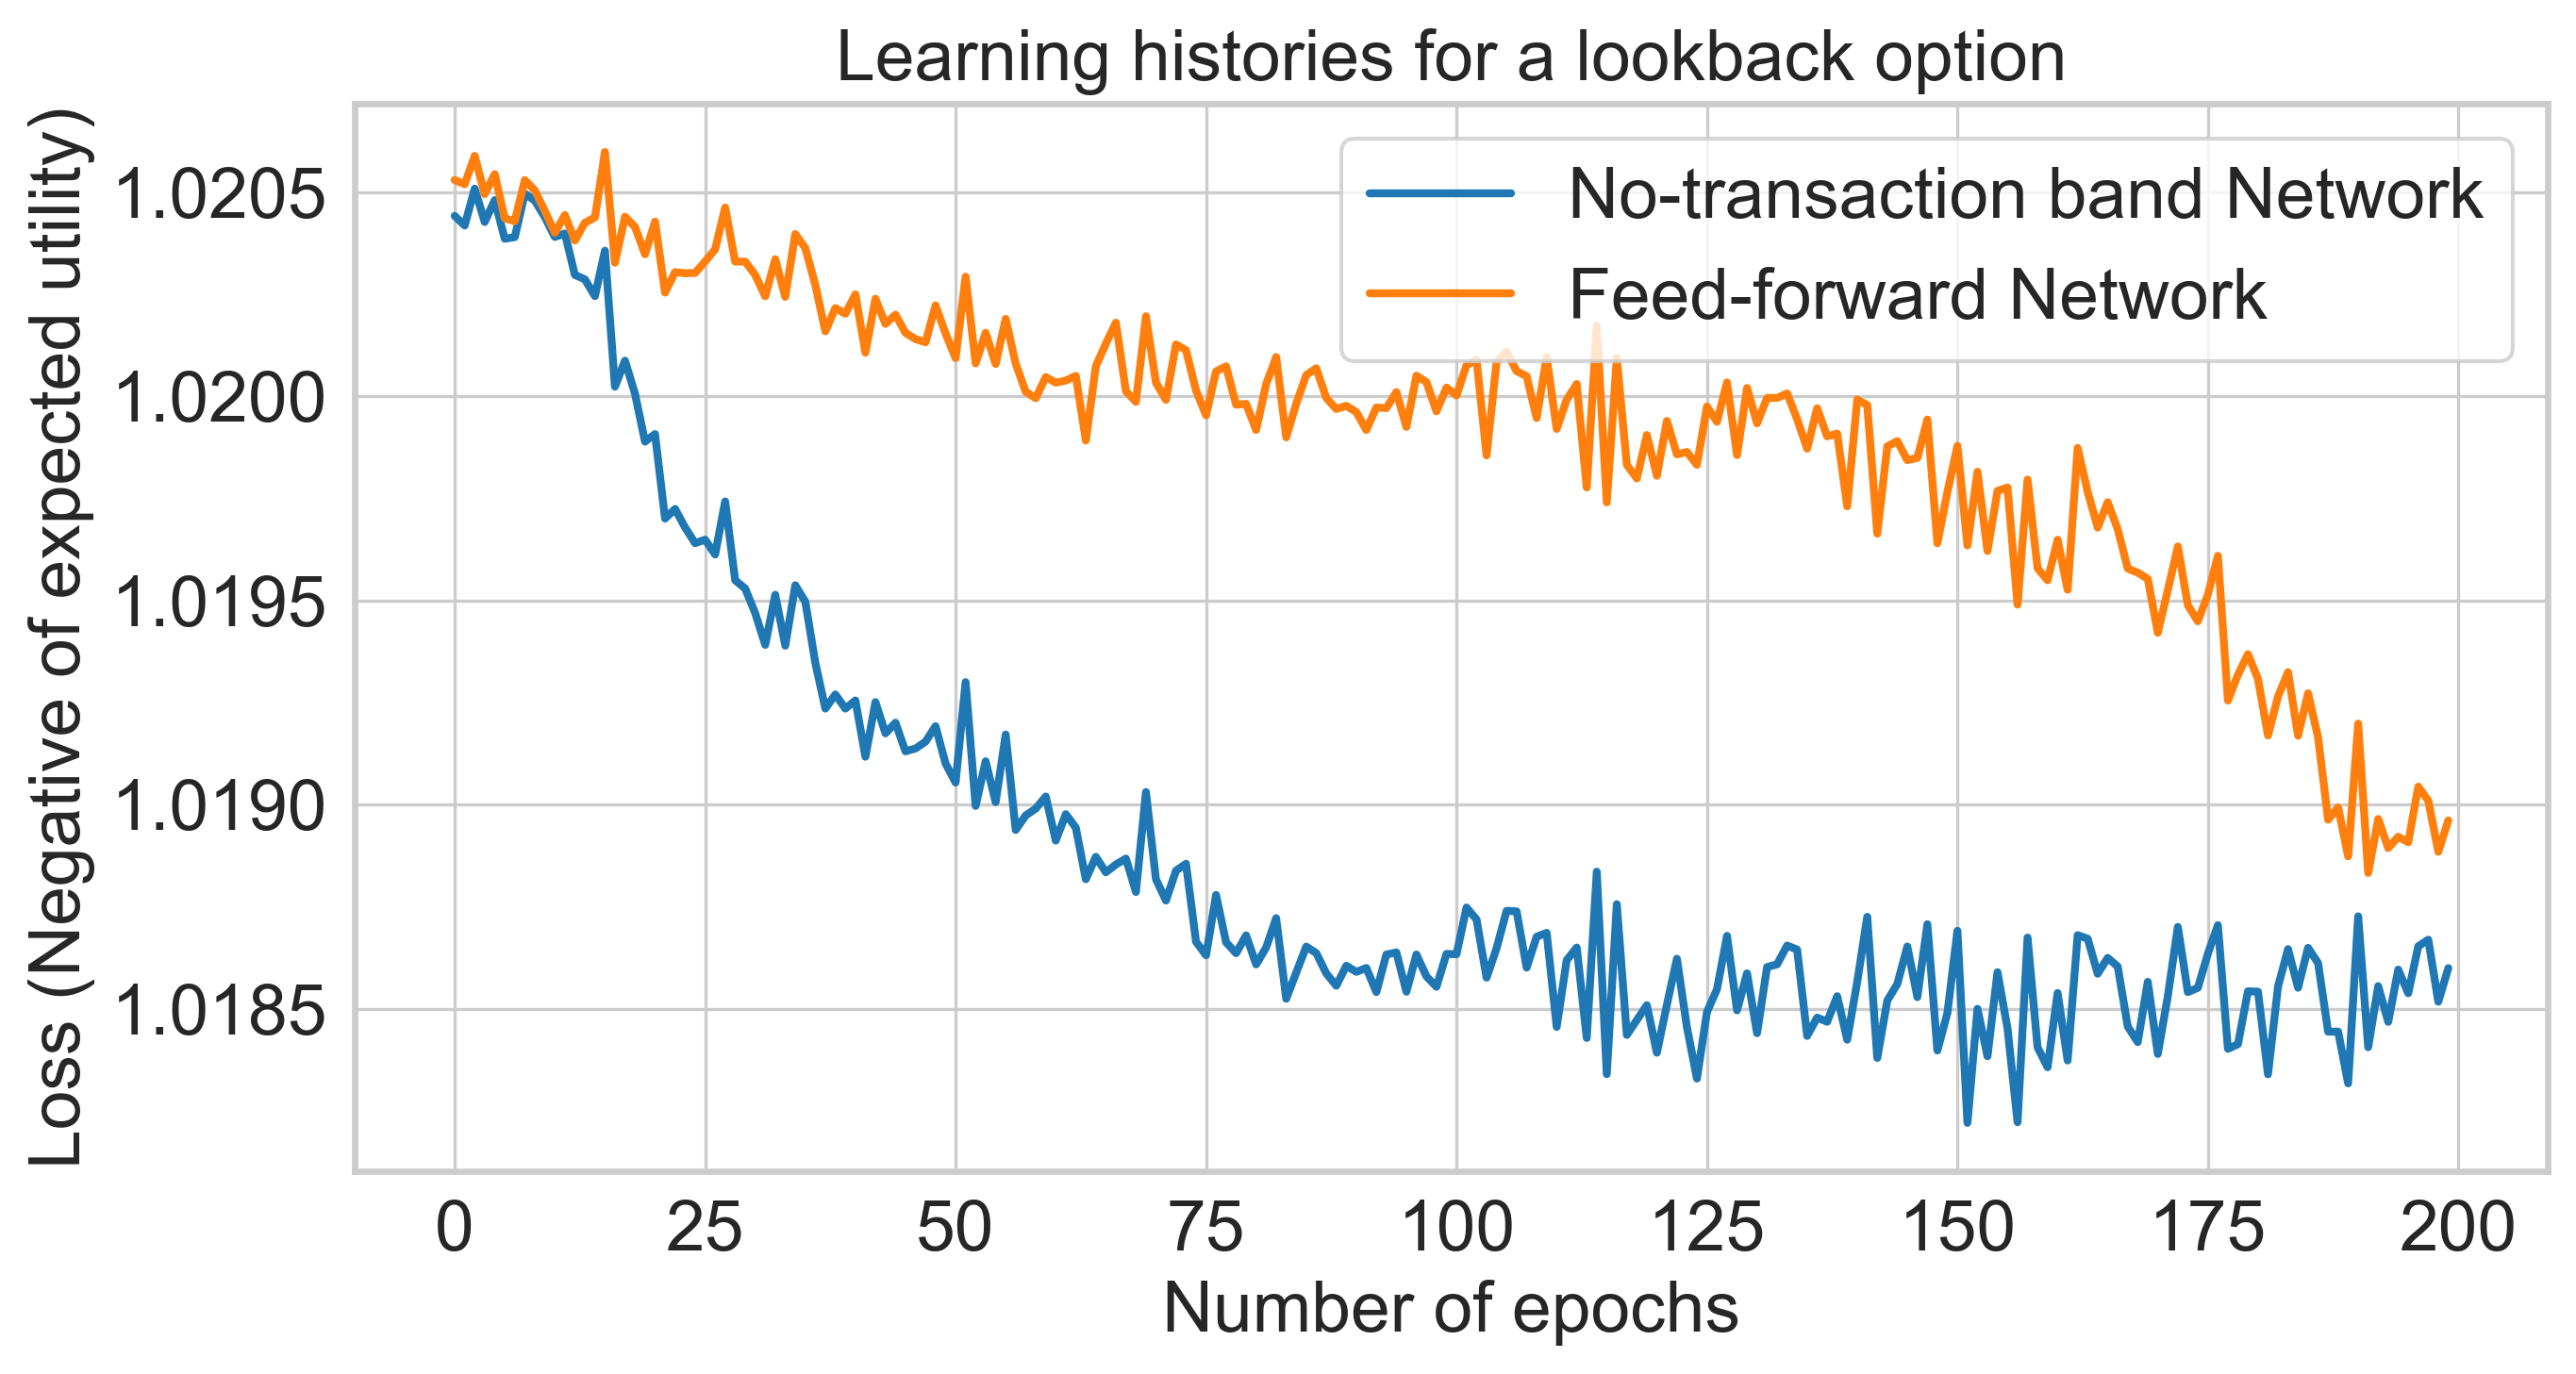

In [27]:
plt.figure()
plt.plot(history_ntb, label="No-transaction band Network")
plt.plot(history_ffn, label="Feed-forward Network")
plt.xlabel("Number of epochs")
plt.ylabel("Loss (Negative of expected utility)")
plt.title("Learning histories for a lookback option")
plt.legend()
plt.show()

Again, the above training histories exhibits that the no-transaction band network can be trained much quicker than the ordinary feed-forward network.

Surprisingly, the no-transaction band network achieves its optima as fast as it learns to hedge a European option, even though the lookback option bears further complication of path-dependence and needs more features.

### Evaluate the best premium of the derivative

In [28]:
torch.manual_seed(42)
premium_ntb = evaluate_premium(model_ntb, lookback_option_payoff, cost=1e-3)
torch.manual_seed(42)
premium_ffn = evaluate_premium(model_ffn, lookback_option_payoff, cost=1e-3)

The no-transaction band network again allows for a cheaper price.

In [29]:
print("Premium of a lookback option evaluated by the no-transaction band network :\t", premium_ntb)
print("Premium of a lookback option evaluated by the feed-forward band network   :\t", premium_ffn)

Premium of a lookback option evaluated by the no-transaction band network :	 0.01830779816955328
Premium of a lookback option evaluated by the feed-forward band network   :	 0.01871226169168949


In [30]:
premium_reduced = (premium_ffn - premium_ntb) / premium_ffn * 100
print("Reduced premium of a lookback option :\t", f"{premium_reduced:.4f} %")

Reduced premium of a lookback option :	 2.1615 %
